In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import tee
import math

In [12]:
#Creating networks
seed = 14
n = 500
m = 5
N_1 = nx.barabasi_albert_graph(n, m, seed)
N_2 = nx.barabasi_albert_graph(n, m, seed)
N_3 = nx.barabasi_albert_graph(n, m, seed)
N_4 = nx.barabasi_albert_graph(n, m, seed)
N_5 = nx.barabasi_albert_graph(n, m, seed)
N_6 = nx.barabasi_albert_graph(n, m, seed)

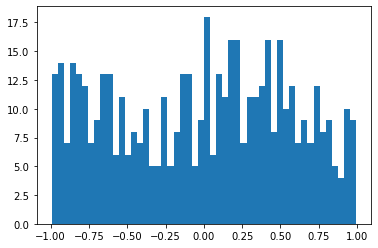

In [13]:
#Initializing set of opinions
initial_opinions = np.random.uniform(-1.0, 1.0, n)
plt.figure()
plt.hist(initial_opinions, bins = 50)
plt.show()

In [14]:
#Make the opinions a dictionary
#Make the perceptions a dictionary
#In the beginning, each node's perception is its own opinion
opinions = {}
perceptions = {}
for node in N_1:
    opinions[node] = initial_opinions[node]
    perceptions[node] = initial_opinions[node]
        
#Assign opinions and perceptions to nodes
nx.set_node_attributes(N_1, opinions, "opinion")
nx.set_node_attributes(N_1, perceptions, "perception")

#define a dictionary to track of the exposed opinions
keys = N_1.nodes()
opinions_exposed_to = {node: [] for node in keys}
nx.set_node_attributes(N_1, opinions_exposed_to, "opinions_exposed_to")

#Defining a dictionary to track the number of times an opinion has been seen
opinion_frequency = {}
#Set to zero initially
for opinion in opinions:
    opinion_frequency[opinion] = 0
nx.set_node_attributes(N_1, opinion_frequency, "opinion_frequency")

In [15]:
#probability selection functions
def pref_attach_opinion(network, sample, k):
    #get the opinions 
    opinions = {}
    opinion = 0
    #Making this list because we can only iterate through the network once
    people = []
    for person in sample:
        opinion = network.nodes[person]['opinion']
        opinions[person] = opinion
        people.append(person)
    #Now we need to select
    opinions_absolute_values = [abs(op) for op in list(opinions.values())]
    opinion_sum = sum(opinions_absolute_values)
    opinions_probabilities = []
    probability = 0
    
    for person in people:
        their_opinion_abs = abs(network.nodes[person]['opinion'])
        their_opinion_frequency = network.nodes[person]['opinion_frequency']
        #Get the opinion frequency:
        if their_opinion_frequency >= 1: #Opinion has been seen at least once before
            probability = math.log(their_opinion_frequency*their_opinion_abs)/(opinion_sum)
        else: #Opinion has not been seen yet
            probability = their_opinion_abs/(opinion_sum)
        opinions_probabilities.append(probability)
        
    
    opinions_exposed = random.choices(list(opinions.values()), weights=opinions_probabilities, k=k)
    
    return opinions_exposed

#uniform probability function
def uniform_opinion(network, sample, k):
    #get the opinions
    opinions = {}
    opinion = 0
    for person in sample:
        opinion = network.nodes[person]['opinion']
        opinions[person] = opinion
       
    #give everything equal weight
    opinions_exposed = random.choices(list(opinions.values()),  k=k)
    return opinions_exposed

In [16]:
#big fancy function

#exposure method: preferential attachment
#initial opinions: random uniform
#intial perceptions: initial opinions
def simulate_1(network, opinions, num_rounds, opinions_per_round, opinion_memory):
    
    #visualize initial perceptions
    #print("Perception Shift")
    #print("Opinion Exposure Method: Preferential")
    #print("Initial Opinions: Random Uniform")
    #print("Initial Perceptions = Initial Opinions")
    #plt.figure()
    #plt.hist(initial_opinions, bins=100)
    #plt.show()
    

    
    #rounds of exposure
    for node in network:
        #rounds of exposure
        new_opinions_exposed_to = []
        for i in range(0, num_rounds):
            #get the neighbors - have to do this in every round bc it returns an iterator
            neighbors = network.neighbors(node)
            opinions_exposed = pref_attach_opinion(network, neighbors, opinions_per_round)
        
            exposure_history = nx.get_node_attributes(network, "opinions_exposed_to")
            opinion_frequencies = nx.get_node_attributes(network, "opinion_frequency")
            exposure_history_this_node = exposure_history[node]
            for new_opinion in opinions_exposed:
                exposure_history_this_node.insert(0, new_opinion)  
                new_opinion_frequency = 1 + opinion_frequencies[node]
                opinion_frequencies[node] = new_opinion_frequency
        
            if len(exposure_history_this_node) > opinion_memory: #More than ten opinions stored
                #Want to keep the ten most recent ones
                exposure_history_this_node = exposure_history_this_node[0:opinion_memory]
            
            #Want to make sure the correct opinions are being saved
            #if node == 0 and i == num_rounds - 1:
                #print(exposure_history_this_node)
            
        exposure_history[node] = exposure_history_this_node
        nx.set_node_attributes(network, exposure_history, "opinions_exposed_to")
        nx.set_node_attributes(network, opinion_frequencies, "opinion_frequency")
        #Take the average opinion, based on total stored exposed opinions
        average_opinion = sum(exposure_history[node])/len(exposure_history[node])
        #Update that nodes perception
        perceptions[node] = average_opinion
    
    
        
    
    #visualize final perceptions
    #plt.figure()
    #plt.hist(list(perceptions.values()), bins=100)
    #plt.show()
    
    #get the average perception magnitude
    perception_abs = [abs(per) for per in list(perceptions.values())]
    
    average_perception = sum(perception_abs)/len(perception_abs)
    
    return num_rounds, average_perception

In [17]:
#simulate_1(N_1, initial_opinions, 10, 1, 10)

In [18]:
def get_average_opinion_abs(network):
    opinions = nx.get_node_attributes(network, "opinion")
    opinion_sum = 0
    num = 0
    for person in opinions:
        opinion_sum += abs(network.nodes[person]['opinion'])
        num += 1
    return opinion_sum/num

In [19]:
def simulate_1_over_time(network, max_num_rounds, opinions_per_round, opinion_memory):
    i = 1
    perceptions = []
    rounds = []
    
    print("Average Perception vs. Number of Exposure Rounds")
    print("Opinion Exposure Method: Preferential")
    print("Initial Opinions: Random Uniform")
    print("Initial Perceptions = Initial Opinions")
    opinions = nx.get_node_attributes(network, "opinion")
    #run the simulation with an increasing number of exposure rounds
    while (i <= max_num_rounds):
        num_rounds, average_perception = simulate_1(network, opinions.values(), i, opinions_per_round, opinion_memory)
        rounds.append(num_rounds)
        perceptions.append(abs(average_perception))
        i += 1
    
    #visualize how the average perception changes with the number of rounds, compare to average opinion
    plt.figure()
    plt.plot(rounds, perceptions)
    average_opinion = get_average_opinion_abs(network)
    opinions_plot = [average_opinion for i in range(num_rounds)]
    plt.plot(rounds, opinions_plot)
    plt.title("Average Perception vs. Number of Rounds")
    plt.xlabel("Number of Rounds")
    plt.ylabel("Average Perception at Conclusion")
    #plt.xticks(rounds)
    plt.show()
    

Average Perception vs. Number of Exposure Rounds
Opinion Exposure Method: Preferential
Initial Opinions: Random Uniform
Initial Perceptions = Initial Opinions


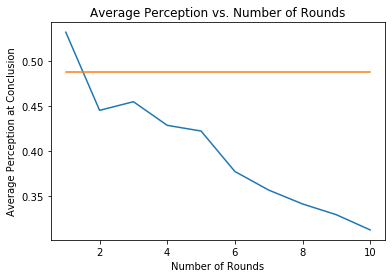

In [20]:
simulate_1_over_time(N_1, 10, 1, 10)

In [21]:
exposed_opinions = nx.get_node_attributes(N_1, "opinions_exposed_to")
print(exposed_opinions[0])

[0.5674275645124869, 0.46525168342861223, 0.5693733774932896, 0.5260304294623024, 0.46525168342861223, 0.6279115441526535, -0.41784844278618705, -0.6328002418849263, 0.3092883992509199, -0.3100638189481124]
